# 0.0 Imports

In [1]:
import numpy                 as np
import pandas                as pd
import seaborn               as sns
import matplotlib.pyplot     as plt

from IPython.core.display    import HTML
from IPython.display         import Image

from scipy                   import stats    as ss
from sklearn                 import metrics  as m

from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import StandardScaler, OneHotEncoder
from sklearn.compose         import ColumnTransformer, make_column_transformer, make_column_selector
from imblearn.over_sampling  import SMOTE
from imblearn.pipeline       import Pipeline


from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier
from sklearn.svm             import SVC


from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.metrics         import accuracy_score, roc_curve, confusion_matrix, classification_report

## 0.1 Helper Functions

In [2]:
def personal_settings(): 
    
    # notbook
    display(HTML('<style>.container{width:98% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.options.display.float_format = '{:.2f}'.format
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(22,10)})
    sns.set_theme(style = 'darkgrid', font_scale = 1.2)
    sns.set_palette('RdBu_r')
    
    return None


def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min( kcorr-1, rcorr-1 )))


def cf_matrix_labels(cf_matrix):
    
    group_names = ['True Negatives','False Positives','False Negatives','True Positives']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    return labels

In [3]:
personal_settings()

## 0.2 Loading Data

In [4]:
directory = 'datasets/olist/' 

orders              = pd.read_csv(directory + 'olist_orders_dataset.csv')
order_items         = pd.read_csv(directory + 'olist_order_items_dataset.csv')
order_payments      = pd.read_csv(directory + 'olist_order_payments_dataset.csv')
order_reviews       = pd.read_csv(directory + 'olist_order_reviews_dataset.csv')
customer            = pd.read_csv(directory + 'olist_customers_dataset.csv')
products            = pd.read_csv(directory + 'olist_products_dataset.csv')
product_translation = pd.read_csv(directory + 'product_category_name_translation.csv')
sellers             = pd.read_csv(directory + 'olist_sellers_dataset.csv')

In [5]:
# merge all datasets that related to the customer
m1 = pd.merge(orders, order_reviews, on='order_id')
m2 = pd.merge(m1, order_payments, on='order_id') 
customer = pd.merge(m2, customer, on='customer_id')

In [6]:
# merge all datasets related to the seller  
m1 = pd.merge(order_items, products, on='product_id')
m2 = pd.merge(m1, sellers, on='seller_id')
seller = pd.merge(m2, product_translation, on='product_category_name')

In [7]:
# merge customer and seller datasets
df_raw = pd.merge(customer, seller, on ='order_id')

# 1.0 Data Description


In [8]:
# filtering useful columns
df1 = df_raw[['order_id', 'order_item_id', 'order_status', 'payment_value', 'price', 'freight_value', 'customer_state', 'seller_state', 'order_purchase_timestamp', 'order_approved_at',
              'order_delivered_customer_date', 'order_estimated_delivery_date','payment_sequential','payment_type','payment_installments',
              'product_category_name_english', 'product_name_lenght','product_description_lenght', 'product_photos_qty','product_weight_g', 'review_score']].copy()

In [9]:
df1.head()

,order_id,order_item_id,order_status,payment_value,price,freight_value,customer_state,seller_state,order_purchase_timestamp,order_approved_at,...,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,1,delivered,18.12,29.99,8.72,SP,SP,2017-10-02 10:56:33,2017-10-02 11:07:15,...,2017-10-18 00:00:00,1,credit_card,1,housewares,40.00,268.00,4.00,500.00,4
1,e481f51cbdc54678b7cc49136f2d6af7,1,delivered,2.00,29.99,8.72,SP,SP,2017-10-02 10:56:33,2017-10-02 11:07:15,...,2017-10-18 00:00:00,3,voucher,1,housewares,40.00,268.00,4.00,500.00,4
2,e481f51cbdc54678b7cc49136f2d6af7,1,delivered,18.59,29.99,8.72,SP,SP,2017-10-02 10:56:33,2017-10-02 11:07:15,...,2017-10-18 00:00:00,2,voucher,1,housewares,40.00,268.00,4.00,500.00,4
3,53cdb2fc8bc7dce0b6741e2150273451,1,delivered,141.46,118.70,22.76,BA,SP,2018-07-24 20:41:37,2018-07-26 03:24:27,...,2018-08-13 00:00:00,1,boleto,1,perfumery,29.00,178.00,1.00,400.00,4
4,47770eb9100c2d0c44946d9cf07ec65d,1,delivered,179.12,159.90,19.22,GO,SP,2018-08-08 08:38:49,2018-08-08 08:55:23,...,2018-09-04 00:00:00,1,credit_card,3,auto,46.00,232.00,1.00,420.00,5


## 1.1 Rename Columns

In [10]:
df1 = df1.rename(columns={'product_category_name_english': 'product_category'})

## 1.2 Data Dimensions

In [11]:
print(df1.shape[0], 'rows')
print(df1.shape[1], 'columns')

115609 rows
21 columns


## 1.3 Data Types

In [12]:
description = []
for i in df1.columns:
    description.append([
        i,
        df1[i].dtypes,
        df1[i].nunique(),
        df1[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data=description, columns=['attributes','dtypes', 'nunique','sample'])

,attributes,dtypes,nunique,sample
0,order_id,object,96516,"[0cc36282e7b0e281bb99dfdc8c0f11aa, 27cc371fc21..."
1,order_item_id,int64,21,"[17, 5]"
2,order_status,object,7,"[approved, canceled]"
3,payment_value,float64,28657,"[76.81, 12.06]"
4,price,float64,5879,"[168.75, 206.9]"
5,freight_value,float64,6954,"[12.59, 129.84]"
6,customer_state,object,27,"[MT, AL]"
7,seller_state,object,23,"[AM, RN]"
8,order_purchase_timestamp,object,95989,"[2018-03-01 21:05:59, 2017-03-04 17:54:28]"
9,order_approved_at,object,88332,"[2017-08-29 22:06:31, 2017-04-25 21:15:12]"


## 1.4 Check NA

In [13]:
description = []
for i in df1.columns:
    description.append([
        i,
        df1[i].isna().sum(),
        round((df1[i].isna().sum()/len(df1))*100)
    ])

pd.DataFrame(data=description, columns=['attributes','null', '%null'])

,attributes,null,%null
0,order_id,0,0
1,order_item_id,0,0
2,order_status,0,0
3,payment_value,0,0
4,price,0,0
5,freight_value,0,0
6,customer_state,0,0
7,seller_state,0,0
8,order_purchase_timestamp,0,0
9,order_approved_at,14,0


The null rows represent less than 3% of the dataset. Removing these rows will not have much impact on the analysis. 

## 1.5 Remove NA

In [14]:
df1.dropna(how='any', inplace=True)

print(df1.shape[0], 'rows')
print(df1.shape[1], 'columns')

113194 rows
21 columns


## 1.6 Change Data Types

In [15]:
cols = ['order_purchase_timestamp', 'order_approved_at', 'order_estimated_delivery_date', 'order_delivered_customer_date']

for col in cols:
    df1[col] = pd.to_datetime(df1[col]).dt.date
    
df1[['order_purchase_timestamp', 'order_approved_at', 'order_estimated_delivery_date', 'order_delivered_customer_date']].head()

,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,order_delivered_customer_date
0,2017-10-02,2017-10-02,2017-10-18,2017-10-10
1,2017-10-02,2017-10-02,2017-10-18,2017-10-10
2,2017-10-02,2017-10-02,2017-10-18,2017-10-10
3,2018-07-24,2018-07-26,2018-08-13,2018-08-07
4,2018-08-08,2018-08-08,2018-09-04,2018-08-17


## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1[['payment_sequential', 'payment_installments', 'payment_value', 'price', 'freight_value', 'product_name_lenght', 
                       'product_description_lenght', 'product_photos_qty', 'product_weight_g']]

cat_attributes = df1[['order_status', 'order_id', 'order_item_id', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date','order_estimated_delivery_date', 
                       'payment_type', 'product_category', 'customer_state', 'seller_state', 'review_score']]

### Numerical Attributes

In [17]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_sequential,113194.00,1.09,0.69,1.00,1.00,1.00,1.00,26.00
payment_installments,113194.00,2.94,2.78,0.00,1.00,2.00,4.00,24.00
payment_value,113194.00,171.56,264.20,0.00,60.85,107.97,189.16,13664.08
price,113194.00,119.85,181.08,0.85,39.90,74.90,132.98,6735.00
freight_value,113194.00,20.00,15.71,0.00,13.08,16.32,21.19,409.68
product_name_lenght,113194.00,48.80,10.02,5.00,42.00,52.00,57.00,76.00
product_description_lenght,113194.00,784.73,650.33,4.00,346.00,600.00,982.00,3992.00
product_photos_qty,113194.00,2.21,1.72,1.00,1.00,1.00,3.00,20.00
product_weight_g,113194.00,2106.28,3765.22,0.00,300.00,700.00,1800.00,40425.00


### Categorical Attributes

In [18]:
cat_summary = cat_attributes.astype('category').describe().T
cat_summary 

,count,unique,top,freq
order_status,113194,2,delivered,113187
order_id,113194,94472,895ab968e7bb0d5659d16cd74cd1650c,63
order_item_id,113194,21,1,99172
order_purchase_timestamp,113194,611,2017-11-24,1379
order_approved_at,113194,608,2018-04-24,1134
order_delivered_customer_date,113194,642,2018-05-21,523
order_estimated_delivery_date,113194,444,2017-12-20,640
payment_type,113194,4,credit_card,83535
product_category,113194,71,bed_bath_table,11684
customer_state,113194,27,SP,47813


# 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

## 2.1 Mind Map

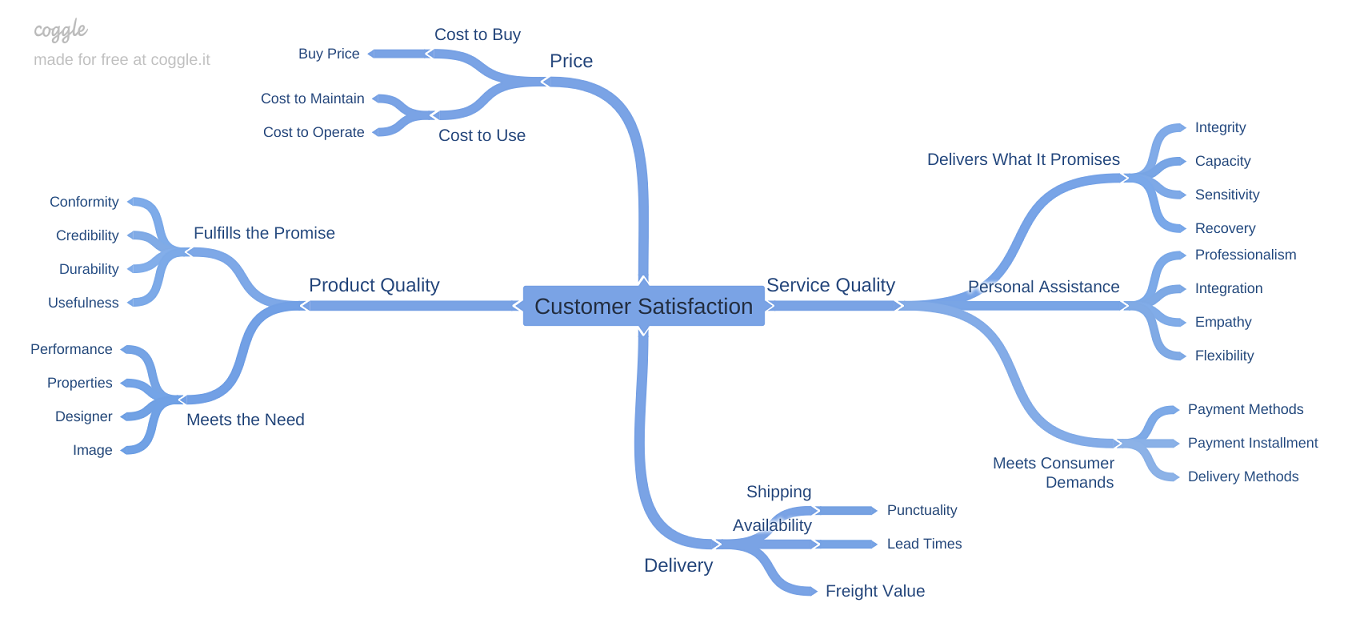

In [20]:
Image('images/mind_map.png')

## 2.2 Hypotesis   
**1.** Customers who pay in more installments tend to give a negative review score. These customers will have been paying for the product for a long time, so they probably expect more.      
**2.** Customers who spend more tend to give a negative review score. If a customer spends more, that customer is likely to expect more.  
**3.** Customers are not satisfied when the delivery of days exceeds the estimated days for delivery, which make them to give a negative review score.     
**4.** Customers are satisfied when the delivery of days are shorter than the estimated delivery dyas, which makes them give positive review scores.  
**5.** Negative review scores have the highest average freight value. In addition to customers not liking to pay for freight, more expensive freight can mean more days for delivery. 

## 2.3 Features Engineering

In [21]:
df2 = df1.copy() 

# extracting days from date columns
df2['estimated_delivery_days']  = df2['order_estimated_delivery_date'] - df2['order_purchase_timestamp']
df2['delivery_days']            = df2['order_delivered_customer_date'] - df2['order_purchase_timestamp']

cols = ['estimated_delivery_days', 'delivery_days']
for col in cols:
    df2[col] = df2[col].apply(lambda x: x.days)

# whether the product arrived on time(1) or not(0)
df2['arrival_on_time'] = df2['estimated_delivery_days'] - df2['delivery_days']
df2['arrival_on_time'] = df2['arrival_on_time'].apply(lambda x: 1 if x >= 1 else 0)

# order status binary transformation -- delivered(1), canceled(0)
df2['order_status'] = df2['order_status'].replace(['canceled','delivered'], [0,1])

# review score binary transformation -- positive review(1), negative review(0)
df2['review_score'] = df2['review_score'].apply(lambda x: 1 if x > 3 else 0)

# remove the timestamps from the dataset, order_id and order_items, since we have already extracted the information we would like  
df2.drop(['order_purchase_timestamp', 'order_approved_at', 'order_estimated_delivery_date', 'order_delivered_customer_date', 'order_id', 'order_item_id'], axis=1,inplace=True)

## 2.5 Split Into Training and Test

In [22]:
df_train, df_test = train_test_split(df2, test_size=0.2, random_state=42)

# 3.0 Exploratory Data Analysis

In [23]:
num_attributes = df_train[['payment_value', 'price', 'freight_value', 'payment_sequential', 'payment_installments', 'product_name_lenght', 'product_description_lenght', 
                           'product_photos_qty', 'product_weight_g', 'estimated_delivery_days', 'delivery_days']]

cat_attributes = df_train[['order_status', 'customer_state', 'seller_state', 'payment_type', 'product_category', 'arrival_on_time', 'review_score']]

## 3.1 Univariate Analysis

### Response Variable

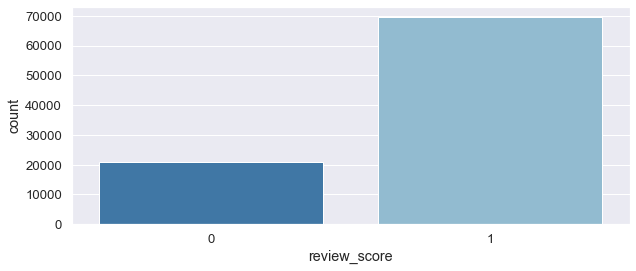

In [24]:
plt.figure(figsize=(10, 4))
sns.countplot(x='review_score', data=df_train);

### Numerical Variables

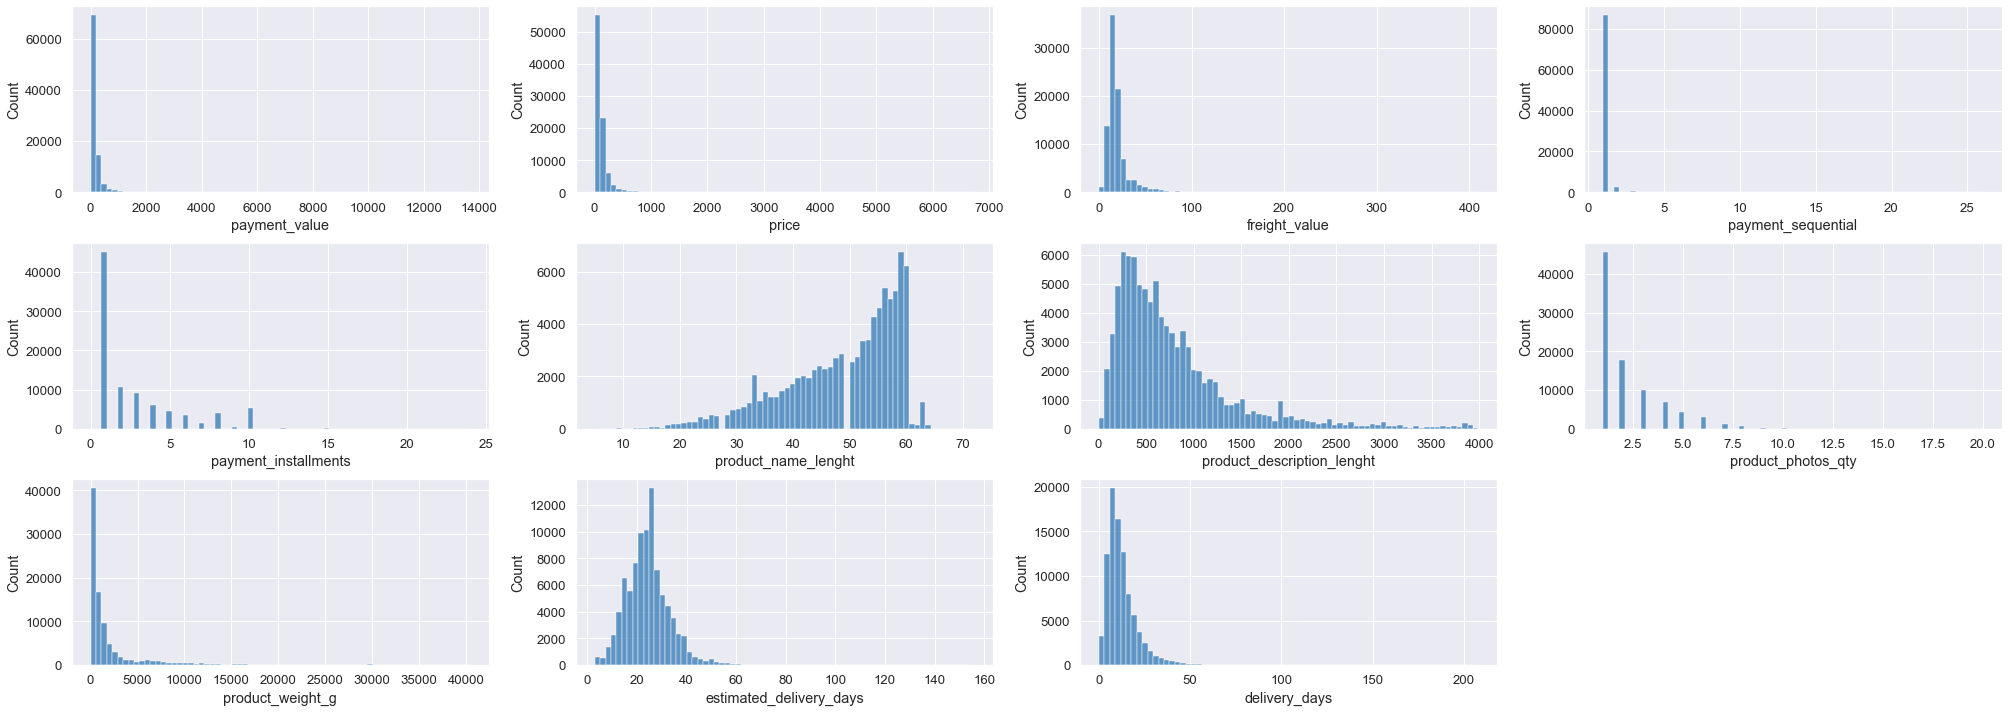

In [25]:
cols = 4
rows = 3
num_cols = num_attributes

fig = plt.figure(figsize= (28, 10))
for i, col in enumerate(num_cols):
    ax=fig.add_subplot( rows, cols, i+1)
    sns.histplot(x=num_attributes[col], bins=70, ax=ax)
    
fig.tight_layout()  
plt.show()

### Categorical Variables

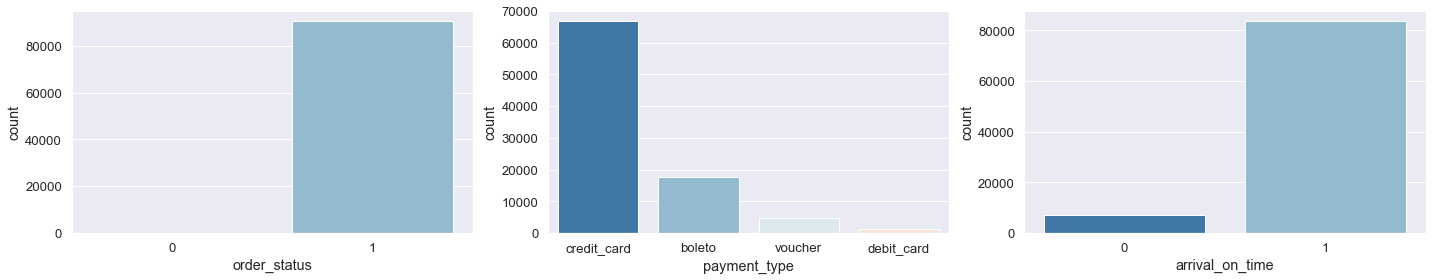

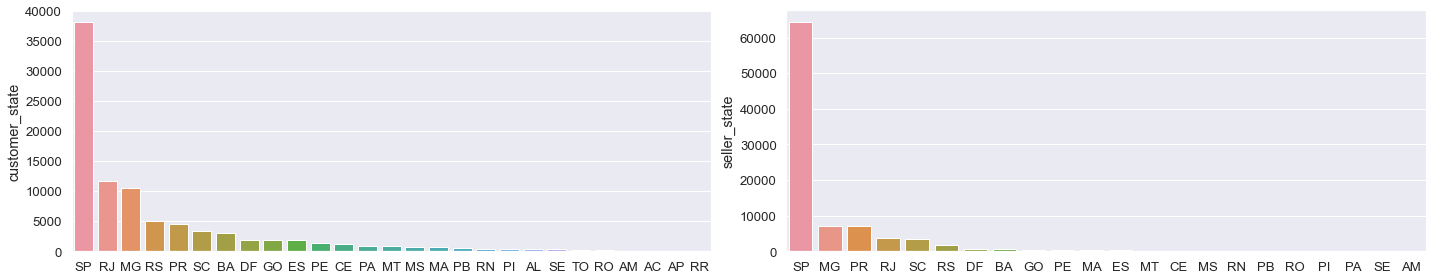

In [26]:
cols = 3
rows = 1 
num_cols = cat_attributes[['order_status', 'payment_type', 'arrival_on_time']]

fig = plt.figure(figsize= (20, 4))
for i, col in enumerate(num_cols):
    ax=fig.add_subplot( rows, cols, i+1)
    sns.countplot(x=cat_attributes[col], ax=ax)
    
fig.tight_layout()       
plt.show()

cols = 2
rows = 1 
num_cols = cat_attributes[['customer_state', 'seller_state']]

fig = plt.figure(figsize= (20, 4))
for i, col in enumerate(num_cols):
    ax=fig.add_subplot( rows, cols, i+1)
    sns.barplot(x=cat_attributes[col].value_counts().index,
                y=cat_attributes[col].value_counts(), ax=ax)
    
fig.tight_layout()       
plt.show() 

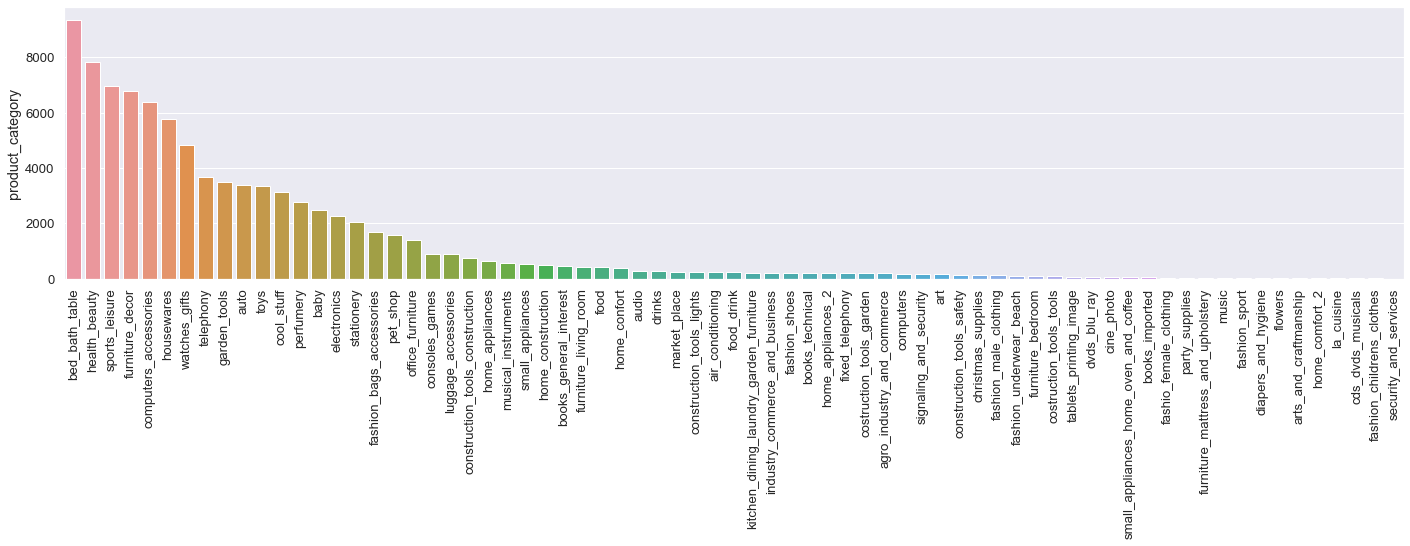

In [27]:
plt.figure(figsize= (24, 5))
sns.barplot(x=cat_attributes['product_category'].value_counts().index,
            y=cat_attributes['product_category'].value_counts())
plt.xticks(rotation=90);

## 3.2 Multivariate Analysis

### Top 10 highest price categories

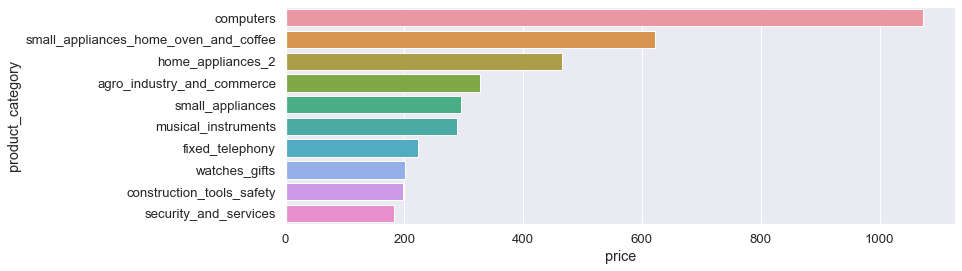

In [28]:
aux = df_train[['product_category', 'price']].groupby('product_category').mean().sort_values('price', ascending=False).reset_index()[:10]
plt.figure(figsize=(12, 4))
sns.barplot(y='product_category', x='price', data=aux);

When we check the price by product category, we can see that the average cost of a product is the highest for items belonging to the 'computers' category. The average price is 1100.     
The second highest category has an average price of 750.

### Payment type based on payment value

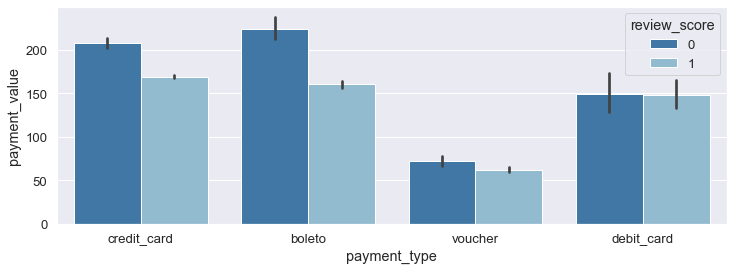

In [29]:
plt.figure(figsize=(12, 4))
sns.barplot(x = 'payment_type', y = 'payment_value', hue='review_score', data=df_train);

Credit cards have the highest payment value, followed by boleto, debit cards, and vouchers.      
The type of payment doesn't seem to influence the review score.

In [30]:
aux = df_train[['payment_type', 'payment_value']].groupby('payment_type').count().sort_values('payment_value', ascending=False).reset_index()
aux['cumu%'] = (aux['payment_value'].cumsum()/aux['payment_value'].sum())*100
aux.head()

,payment_type,payment_value,cumu%
0,credit_card,66738,73.70
1,boleto,17697,93.24
2,voucher,4844,98.59
3,debit_card,1276,100.00


More than 70% of values payments, were made with credit cards.

### Review score based on payment installments

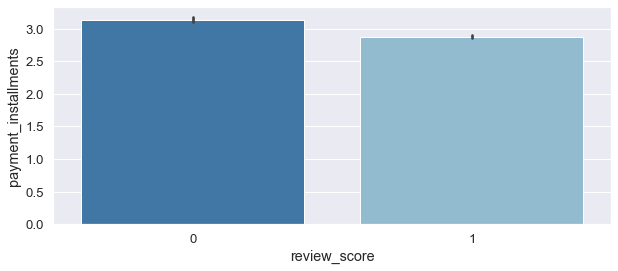

In [31]:
plt.figure(figsize=(10, 4))
sns.barplot(y='payment_installments', x='review_score', data=df_train);

In [32]:
aux = df_train[['review_score', 'payment_installments']].groupby('review_score').mean().reset_index()
print(aux)

negative = aux.iloc[0,1]
positive = aux.iloc[1,1]

percentage = abs(((negative - positive) / positive)*100)
percentage 
print(f'\n Negative review scores have {percentage:.2f}% more payment installments than positive review scores.')

   review_score  payment_installments
0             0                  3.14
1             1                  2.88

 Negative review scores have 9.06% more payment installments than positive review scores.


###  Review score based on payment value

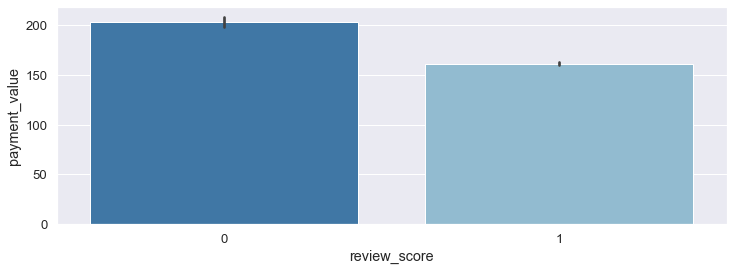

In [33]:
plt.figure(figsize=(12, 4))
sns.barplot(x = 'review_score', y = 'payment_value', data=df_train);

In [34]:
aux = df_train[['review_score', 'payment_value']].groupby('review_score').mean().reset_index()
print(aux)

negative = aux.iloc[0,1]
positive = aux.iloc[1,1]

percentage = abs(((negative - positive) / positive)*100)
print(f'\n Negative review scores have a payment value {percentage:.2f}% higher than positive review scores.')

   review_score  payment_value
0             0         202.98
1             1         161.38

 Negative review scores have a payment value 25.78% higher than positive review scores.


### Review score based on product price

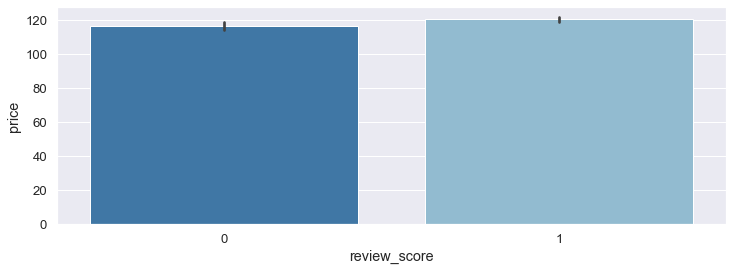

In [35]:
plt.figure(figsize=(12, 4))
sns.barplot(x = 'review_score', y = 'price', data=df_train);

In [36]:
aux = df_train[['review_score', 'price']].groupby('review_score').mean().reset_index()
print(aux)

negative = aux.iloc[0,1]
positive = aux.iloc[1,1]

percentage = abs(((positive - negative) / negative)*100)
print(f'\n Negative scores have a product price {percentage:.2f}% higher than positive review scores.')

   review_score  price
0             0 116.89
1             1 120.70

 Negative scores have a product price 3.26% higher than positive review scores.


### Review score based on freight value 

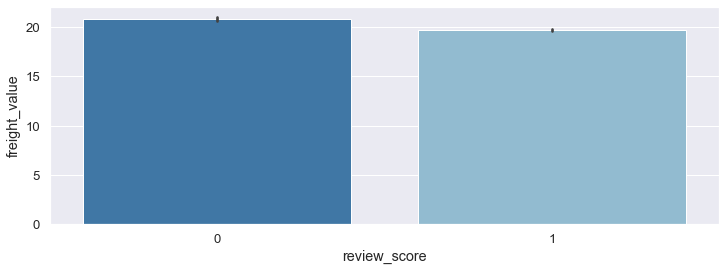

In [37]:
plt.figure(figsize=(12, 4))
sns.barplot(x = 'review_score', y = 'freight_value', data=df_train);

In [38]:
aux = df_train[['review_score', 'freight_value']].groupby('review_score').mean().reset_index()
print(aux)

negative = aux.iloc[0,1]
positive = aux.iloc[1,1]

percentage = abs(((negative - positive) / positive)*100)
percentage 
print(f'\n Negative review scores have a freight value {percentage:.2f}% more expensive than positive review scores.')

   review_score  freight_value
0             0          20.80
1             1          19.71

 Negative review scores have a freight value 5.52% more expensive than positive review scores.


### The number of orders that arrived on time or not by review score type

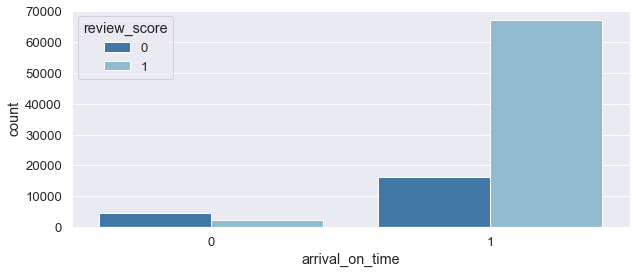

In [39]:
plt.figure(figsize=(10, 4))
sns.countplot(x = 'arrival_on_time', hue='review_score', data=df_train);

Orders that arrive on time have a far more positive review score while orders that don't arrive on time have more negative reviews.

### Correlation between estimated delivery and delivery days

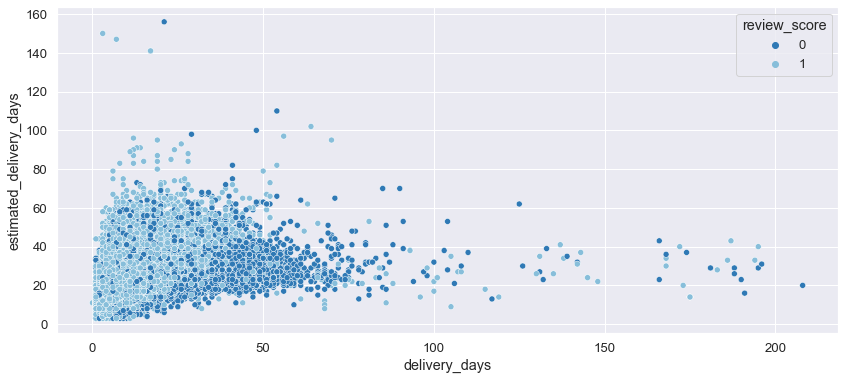

In [40]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x='delivery_days', y='estimated_delivery_days', hue='review_score', data=df_train);

* Most positive reviews have long estimated delivery days, but the actual delivery days are before or on schedule. 
* Most negative review scores have short estimated delivery days, but the actual delivery days of the product are longer than the expected time.

### Correlation matrix between the numerical variables in the dataset

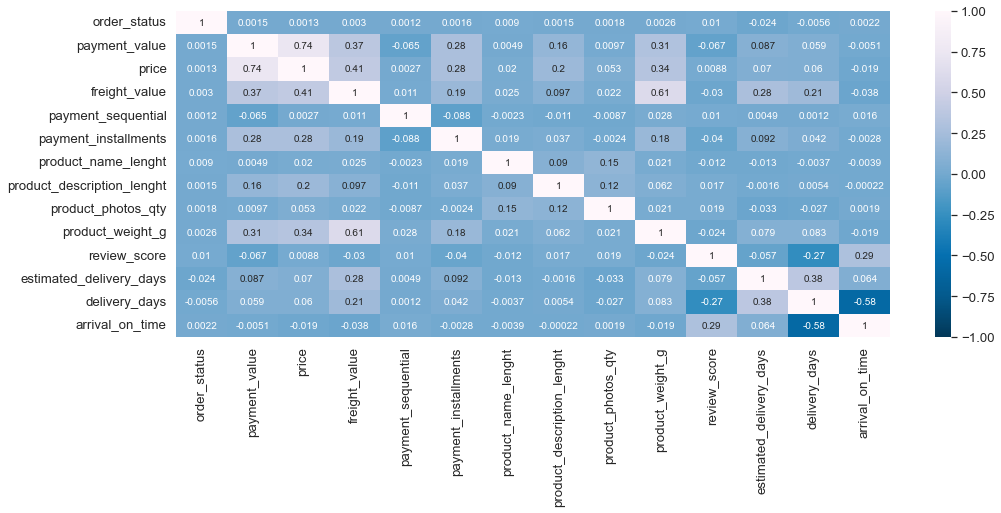

In [41]:
corr = df_train.corr(method='pearson')

plt.figure(figsize=(16, 6))
sns.heatmap(corr, cmap='PuBu_r', vmin=-1, vmax=1, annot=True);

* The freight value has a positive correlation with the estimated days. It makes sense, the more days to delivery, the higher the freight (further away).   
* Delivery days have a negative correlation with the customer review score. It makes sense, the longer it takes for the customer to receive the order, the worse the customer review score will be. 

### Correlation matrix between the categorical variables in the dataset

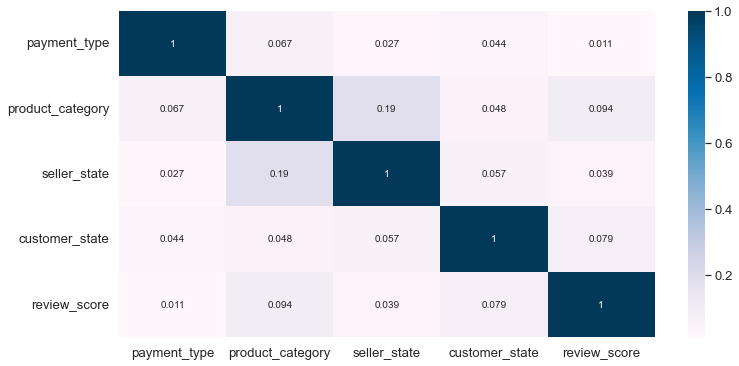

In [42]:
a = df_train[['payment_type', 'product_category','seller_state', 'customer_state', 'review_score']]

# calculate cramer V
a1  = cramer_v(a['payment_type'], a['payment_type'    ])
a2  = cramer_v(a['payment_type'], a['product_category'])
a3  = cramer_v(a['payment_type'], a['seller_state'    ])
a4  = cramer_v(a['payment_type'], a['customer_state'  ])
a5  = cramer_v(a['payment_type'], a['review_score'    ])

a6  = cramer_v(a['product_category'], a['payment_type'    ])
a7  = cramer_v(a['product_category'], a['product_category'])
a8  = cramer_v(a['product_category'], a['seller_state'    ])
a9  = cramer_v(a['product_category'], a['customer_state'  ])
a10 = cramer_v(a['product_category'], a['review_score'    ])

a11 = cramer_v(a['seller_state'], a['payment_type'    ])
a12 = cramer_v(a['seller_state'], a['product_category'])
a13 = cramer_v(a['seller_state'], a['seller_state'    ])
a14 = cramer_v(a['seller_state'], a['customer_state'  ])
a15 = cramer_v(a['seller_state'], a['review_score'    ])

a16 = cramer_v(a['customer_state'], a['payment_type'    ])
a17 = cramer_v(a['customer_state'], a['product_category'])
a18 = cramer_v(a['customer_state'], a['seller_state'    ])
a19 = cramer_v(a['customer_state'], a['customer_state'  ])
a20 = cramer_v(a['customer_state'], a['review_score'    ])
               
a21 = cramer_v(a['review_score'], a['payment_type'    ])
a22 = cramer_v(a['review_score'], a['product_category'])
a23 = cramer_v(a['review_score'], a['seller_state'    ])
a24 = cramer_v(a['review_score'], a['customer_state'  ])
a25 = cramer_v(a['review_score'], a['review_score'    ])

# final dataset
d = pd.DataFrame({'payment_type':      [a1,  a2,  a3,  a4,  a5  ], 
                   'product_category': [a6,  a7,  a8,  a9,  a10 ],
                   'seller_state':     [a11, a12, a13, a14, a15 ],
                   'customer_state':   [a16, a17, a18, a19, a20 ],
                   'review_score':     [a21, a22, a23, a24, a25 ]})

d = d.set_index(d.columns)

plt.figure(figsize=(12, 6))
sns.heatmap(d, annot=True, cmap='PuBu');

# 4.0 ML Modeling

It is certain that there is a high class imbalance in the dataset.     
A negative review score (0) is very important, since misclassifying them would cause the seller to lose customers. The false positive should be the concern here.

## 4.1 Data Preparation

###  Rescaling

In [43]:
num_features = [['order_status', 'payment_value', 'price', 'freight_value', 'payment_sequential', 'payment_installments', 'product_name_lenght', 
                 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'estimated_delivery_days', 'delivery_days', 'arrival_on_time']]

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                  ('scaler',  StandardScaler())])

### Encoding

In [44]:
cat_features = [['customer_state', 'seller_state', 'payment_type', 'product_category']]

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse=False))])

### Transformation Pipeline

In [45]:
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features),
                                               ('cat', cat_transformer, cat_features)])

preprocessor = make_column_transformer((num_transformer, make_column_selector(dtype_include=np.number)), 
                                       (cat_transformer, make_column_selector(dtype_include=object)))

In [46]:
## how we can get a DataFrame out after transformation pipeline if we want
#X_train_t = preprocessor.fit_transform(X_train)
#
#X_train_t_df = pd.DataFrame(X_train_t, 
#                            columns=preprocessor.get_feature_names_out(),
#                            index=X_train.index)
#
#X_train_t_df.head(2)

### Separete Target

In [47]:
df_train = df_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

X_train  = df_train.drop("review_score", axis=1)
y_train  = df_train["review_score"].copy()

X_test = df_test.drop("review_score", axis=1)
y_test = df_test["review_score"].copy()

## 4.2 ML Evaluation

### Models Baseline

In [48]:
model_pipeline = []
model_pipeline.append(LogisticRegression(solver='newton-cg'))
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(XGBClassifier())

### ML Evaluation

In [49]:
model_list = ['Logistic Regression', 'SVM', 'KNN', 'Decision Tree', 'Random Forest', 'XGB']

acuracy_list  = []
auc_list = []
n_precision_list = []
p_precision_list = []
macro_precision_list = []
n_recall_list = []
p_recall_list  = []
macro_recall_list = []
n_fscore_list = []
p_fscore_list = []
macro_fscore_list = []
cm_list = []

for model in model_pipeline:
    
    # defining a global seed
    np.random.seed(7)
    
    # full pipeline
    preprocessor = preprocessor
    oversample   = SMOTE(random_state=14)
    model        = model
    
    steps = [('preprocessor', preprocessor), ('oversample', oversample), ('model', model)]

    pipeline = Pipeline(steps=steps)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    ## ml evaluation
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # acuracy
    acuracy_list.append(report['accuracy'])
    
    # precision
    n_precision_list.append(report['0']['precision'])
    p_precision_list.append(report['1']['precision'])
    macro_precision_list.append(report['macro avg']['precision'])
    
    #recall
    n_recall_list.append(report['0']['recall'])
    p_recall_list.append(report['1']['recall'])
    macro_recall_list.append(report['macro avg']['recall'])
    
    # f1-score
    n_fscore_list.append(report['0']['f1-score'])
    p_fscore_list.append(report['1']['f1-score'])
    macro_fscore_list.append(report['macro avg']['f1-score'])

    # ROC, AUC and confusion Matrix
    fpr, tpr, _thresholds = roc_curve(y_test, y_pred)
    auc_list.append(round(m.auc(fpr, tpr), 2))
    cm_list.append(confusion_matrix(y_test, y_pred))

### Confusion Matrix

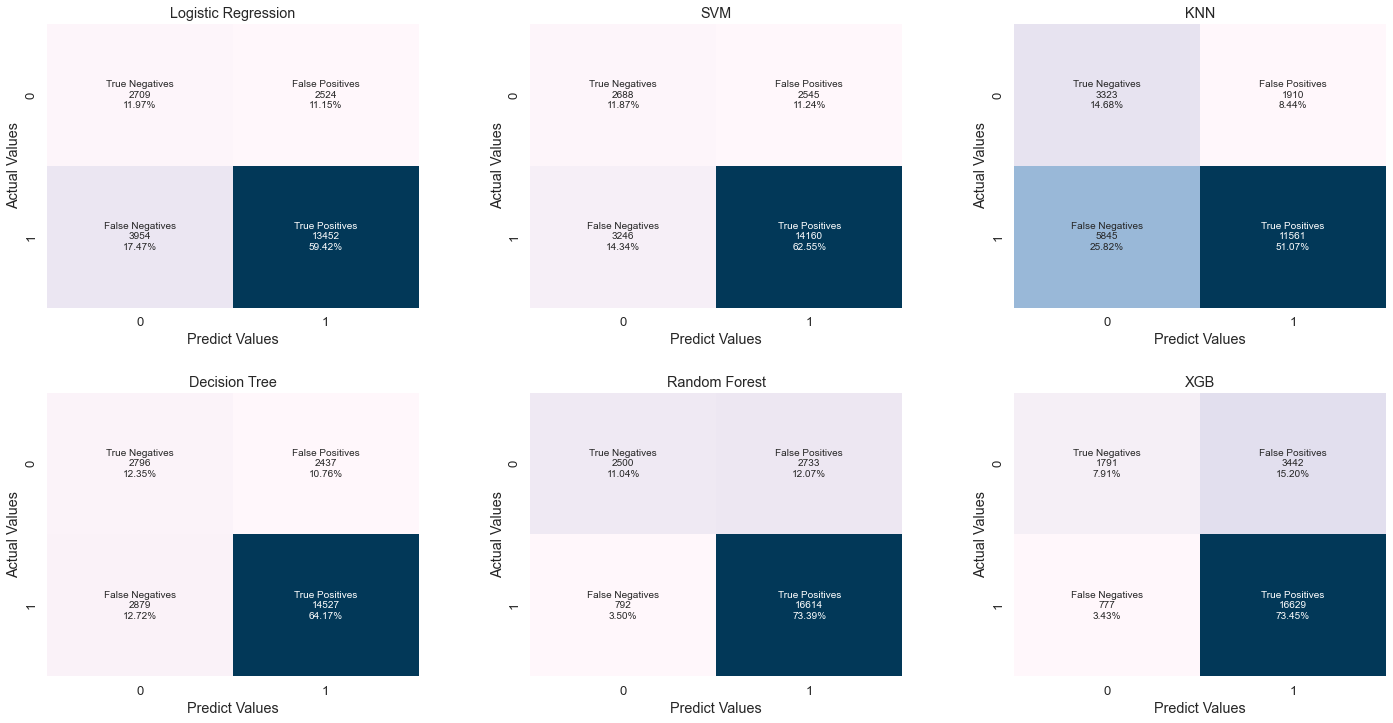

In [50]:
fig = plt.figure(figsize=(24, 12))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    
    sub = fig.add_subplot(2, 3, i+1)
    cm_plot = sns.heatmap(cm, annot=cf_matrix_labels(cm), fmt='', cmap='PuBu', cbar=False)
    cm_plot.set_title(model)
    cm_plot.set_xlabel('Predict Values')
    cm_plot.set_ylabel('Actual Values') 
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

### Evaluation Results

In [51]:
df_results = pd.DataFrame({'Model'        : model_list, 
                           'Accuracy'     : acuracy_list, 
                           'AUC'          : auc_list,
                           'Precision (0)': n_precision_list, 
                           'Precision (1)': p_precision_list,
                           'Recall (0)'   : n_recall_list,     
                           'Recall (1)'   : p_recall_list, 
                           'F1-Score (0)' : n_fscore_list ,     
                           'F1-Score (1)' : p_fscore_list,
                           'Precision'    : macro_precision_list, 
                           'Recall'       : macro_recall_list, 
                           'F1-Score'     : macro_fscore_list})

df_results.style.highlight_max(subset=['Accuracy', 'AUC', 'Precision (0)', 'Precision (1)', 'Recall (0)', 'Recall (1)', 
                                       'F1-Score (0)','F1-Score (1)', 'Precision', 'Recall', 'F1-Score'], color='lightblue', axis=0)

,Model,Accuracy,AUC,Precision (0),Precision (1),Recall (0),Recall (1),F1-Score (0),F1-Score (1),Precision,Recall,F1-Score
0,Logistic Regression,0.713857,0.650000,0.406574,0.842013,0.517676,0.772837,0.455447,0.805943,0.624293,0.645257,0.630695
1,SVM,0.744202,0.660000,0.452983,0.847650,0.513663,0.813513,0.481418,0.830231,0.650317,0.663588,0.655825
2,KNN,0.657450,0.650000,0.362456,0.858214,0.635009,0.664196,0.461496,0.748842,0.610335,0.649602,0.605169
3,Decision Tree,0.765184,0.680000,0.492687,0.856343,0.534302,0.834597,0.512651,0.845330,0.674515,0.684449,0.678991
4,Random Forest,0.844295,0.720000,0.759417,0.858738,0.477737,0.954498,0.586510,0.904089,0.809077,0.716118,0.745300
5,XGB,0.813640,0.650000,0.697430,0.828509,0.342251,0.955360,0.459172,0.887424,0.762969,0.648806,0.673298


We will discard Random Forest and XGB, as they had lowers recall for negative review scores. We will follow with the others to improve the algorithms' performance by making a manual selection of features considering the exploratory data analysis. 

# 5.0 Tunnig ML Models

## 5.1 Data Preparation

### Features Selection

Since the dataset has few variables it was possible to do some performance tests and eliminate some variables from our model manually based on the exploratory analysis, this was the final result of variables to be excluded from the model: order_status, payment_type, payment_sequential, product_name_lenght.

In [52]:
X_train  = df_train.drop(["review_score", 'order_status','payment_type', 'payment_sequential', 'product_name_lenght'], axis=1)
y_train  = df_train["review_score"].copy()

X_test = df_test.drop(["review_score", 'order_status', 'payment_type', 'payment_sequential', 'product_name_lenght'], axis=1)
y_test = df_test["review_score"].copy()

### Rescaling

In [53]:
num_features = [['payment_value', 'price', 'freight_value','payment_installments', 'product_weight_g', 'product_description_lenght', 
                 'product_photos_qty', 'estimated_delivery_days', 'delivery_days', 'arrival_on_time']]

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                  ('scaler',  StandardScaler())])

### Encoding

In [54]:
cat_features = [['customer_state',  'seller_state', 'product_category']]

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse=False))])

### Transformation Pipeline

In [55]:
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features),
                                               ('cat', cat_transformer, cat_features)])

preprocessor = make_column_transformer((num_transformer, make_column_selector(dtype_include=np.number)), 
                                       (cat_transformer, make_column_selector(dtype_include=object)))

## 5.2 ML Evaluation

#### Models Baseline

In [56]:
model_pipeline = []
model_pipeline.append(LogisticRegression(solver='newton-cg'))
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())

### ML Evaluation

In [57]:
model_list = ['Logistic Regression', 'SVM', 'KNN', 'Decision Tree']

acuracy_list  = []
auc_list = []
n_precision_list = []
p_precision_list = []
macro_precision_list = []
n_recall_list = []
p_recall_list  = []
macro_recall_list = []
n_fscore_list = []
p_fscore_list = []
macro_fscore_list = []
cm_list = []

for model in model_pipeline:
    
    # defining a global seed
    np.random.seed(7)
    
    # full pipeline
    preprocessor = preprocessor
    oversample   = SMOTE(random_state=14)
    model        = model
    
    steps = [('preprocessor', preprocessor), ('oversample', oversample), ('model', model)]

    pipeline = Pipeline(steps=steps)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    ## ml evaluation
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # acuracy
    acuracy_list.append(report['accuracy'])
    
    # precision
    n_precision_list.append(report['0']['precision'])
    p_precision_list.append(report['1']['precision'])
    macro_precision_list.append(report['macro avg']['precision'])
    
    #recall
    n_recall_list.append(report['0']['recall'])
    p_recall_list.append(report['1']['recall'])
    macro_recall_list.append(report['macro avg']['recall'])
    
    # f1-score
    n_fscore_list.append(report['0']['f1-score'])
    p_fscore_list.append(report['1']['f1-score'])
    macro_fscore_list.append(report['macro avg']['f1-score'])

    # ROC, AUC and confusion Matrix
    fpr, tpr, _thresholds = roc_curve(y_test, y_pred)
    auc_list.append(round(m.auc(fpr, tpr), 2))
    cm_list.append(confusion_matrix(y_test, y_pred))

### Confusion Matrix

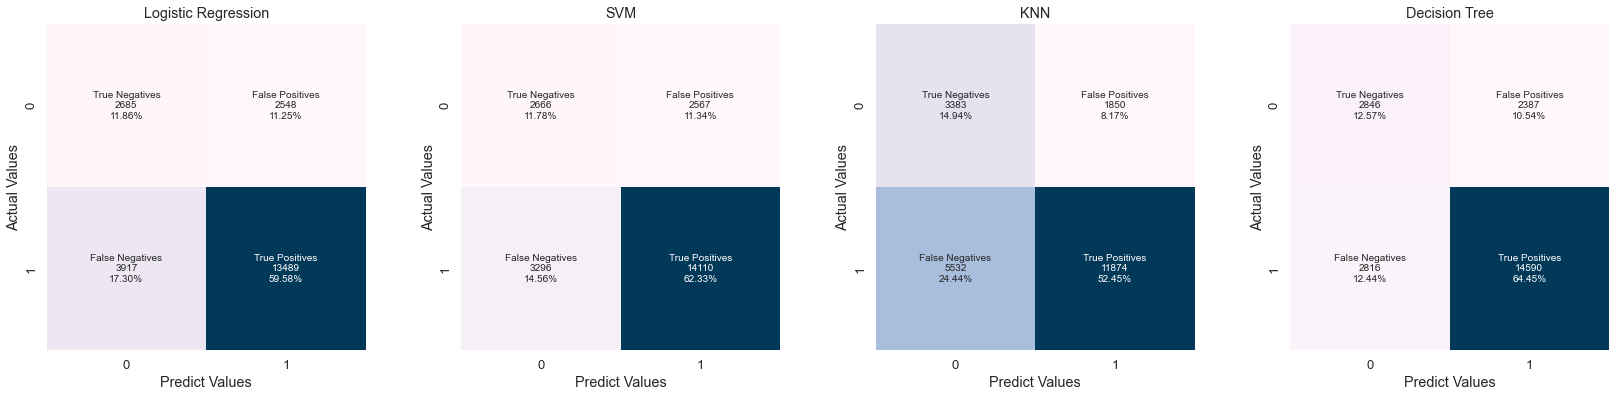

In [58]:
fig = plt.figure(figsize=(28, 6))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    
    sub = fig.add_subplot(1, 4 , i+1)
    cm_plot = sns.heatmap(cm, annot=cf_matrix_labels(cm), fmt='', cmap='PuBu', cbar=False)
    cm_plot.set_title(model)
    cm_plot.set_xlabel('Predict Values')
    cm_plot.set_ylabel('Actual Values') 
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

### Evaluation Results

In [59]:
df_results = pd.DataFrame({'Model'        : model_list, 
                           'Accuracy'     : acuracy_list, 
                           'AUC'          : auc_list,
                           'Precision (0)': n_precision_list, 
                           'Precision (1)': p_precision_list,
                           'Recall (0)'   : n_recall_list,     
                           'Recall (1)'   : p_recall_list, 
                           'F1-Score (0)' : n_fscore_list ,     
                           'F1-Score (1)' : p_fscore_list,
                           'Precision'    : macro_precision_list, 
                           'Recall'       : macro_recall_list, 
                           'F1-Score'     : macro_fscore_list})

display(df_results.style.highlight_max(subset=['Accuracy', 'AUC', 'Precision (0)', 'Precision (1)', 'Recall (0)', 'Recall (1)', 
                                               'F1-Score (0)', 'F1-Score (1)', 'Precision', 'Recall', 'F1-Score'], color='lightblue', axis=0))

,Model,Accuracy,AUC,Precision (0),Precision (1),Recall (0),Recall (1),F1-Score (0),F1-Score (1),Precision,Recall,F1-Score
0,Logistic Regression,0.714431,0.640000,0.406695,0.841117,0.513090,0.774963,0.453739,0.806686,0.623906,0.644026,0.630212
1,SVM,0.741022,0.660000,0.447165,0.846075,0.509459,0.810640,0.476284,0.827979,0.646620,0.660050,0.652131
2,KNN,0.673926,0.660000,0.379473,0.865200,0.646474,0.682179,0.478230,0.762865,0.622336,0.664326,0.620548
3,Decision Tree,0.770175,0.690000,0.502649,0.859398,0.543856,0.838217,0.522441,0.848675,0.681024,0.691037,0.685558


We see an improvement in the metrics across algorithms, KNN achieved a recall of 0.65 for negative review scores and a precision of 0.86 for positive review scores, following the business assumptions for negative review scores recall is more important and for positive review scores, precision is more important. But before making a decision on which algorithm to proceed with, let's cross-validate.

### Cross-Validation

In [60]:
scores_list = []

for model in model_pipeline:
    
    # defining a global seed
    np.random.seed(7)
    
    # ml pipeline
    preprocessor = preprocessor
    oversample   = SMOTE(random_state=14)
    model        = model
    
    steps = [('preprocessor', preprocessor), ('oversample', oversample), ('model', model)]

    pipeline = Pipeline(steps=steps)
    
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv)
    
    scores_list.append(np.round(scores.mean(), 3).astype(str) + ' +/- ' + np.round(scores.std(), 4).astype(str))

In [61]:
modelling_result_cv = pd.DataFrame({'Model': model_list, 'ACC CV': scores_list})
modelling_result_cv       

,Model,ACC CV
0,Logistic Regression,0.715 +/- 0.0026
1,SVM,0.739 +/- 0.0024
2,KNN,0.664 +/- 0.0016
3,Decision Tree,0.757 +/- 0.0025


From now on I will either use the KNN algorithm, since it performs better than all the others tested in the recall for negative score reviews. I will fine tune the KNN algorithm to find the parameter combination that delivers the best possible performance for balanced accuracy.

# 6.0 KNN Hyperparameter Tuning 

## 6.1 Search 

In [62]:
# defining a global seed
np.random.seed(7)
    
# ml pipeline
preprocessor = preprocessor
oversample   = SMOTE(random_state=14)
model        = KNeighborsClassifier()
  
steps = [('preprocessor', preprocessor), ('oversample', oversample), ('model', model)]
pipeline = Pipeline(steps=steps)

param_grid  = [{'model__n_neighbors': [3, 6, 12],
                 'model__weights'   : ['uniform', 'distance']}]

grid = GridSearchCV(pipeline, param_grid, cv=10, scoring='balanced_accuracy', verbose=0)
grid = grid.fit(X_train, y_train)

In [63]:
print ('Score:', grid.best_score_)
print ('Parameters: ', grid.best_params_)

Score: 0.686001710948584
Parameters:  {'model__n_neighbors': 6, 'model__weights': 'distance'}


## 7.0 Final Results and Conclusions

## 7.1 ML Evaluation

### ML Model 

In [64]:
# defining a global seed
np.random.seed(7)
    
# ml pipeline
preprocessor = preprocessor
oversample   = SMOTE(random_state=14)
model        = KNeighborsClassifier(n_neighbors=6, weights='distance')
  
steps = [('preprocessor', preprocessor), ('oversample', oversample), ('model', model)]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

### Confusion Matrix

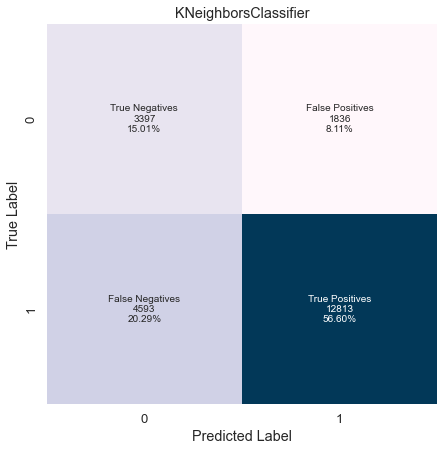

In [65]:
fig, ax = plt.subplots(1,1, figsize=(7,7))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=cf_matrix_labels(cm), fmt='', cmap='PuBu', ax=ax, cbar=False)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('KNeighborsClassifier')

plt.subplots_adjust(hspace=0.3)

### Classification Report

In [66]:
print('KNeighborsClassifier')
print(classification_report(y_test, y_pred))
print('\n')

KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.43      0.65      0.51      5233
           1       0.87      0.74      0.80     17406

    accuracy                           0.72     22639
   macro avg       0.65      0.69      0.66     22639
weighted avg       0.77      0.72      0.73     22639





### Conclusions

By eliminating less relevant predictors and making hyperparameter adjustments we improved the overall performance of the algorithm from an accuracy of 66% to 72% and a considerable improvement in correctly identifying positive review scores from 51.07% to 56.60%. Most important for the business is the correct identification of negative review scores, by eliminating the least relevant predictors and making hyperparameter adjustments, we went from correctly identifying negative review scores from 63% to 65%. 

The model still needs to be improved. Since the predictor variables have a weak relationship with the target variable, working more on feature engineering and using an algorithm for feature selection is something that might help. In any case, we already have a process, scalable and does not rely on subjective decisions, which generates time and resource savings. 